# Looking into the score distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load_scores(model_name, component):
    filepath = f'../Models/{model_name}/savedModels/{model_name}_Yelp_{component}_7135User.npy'
    return np.load(filepath)

In [4]:
U = load_scores('USG', 'U')
print(f"U: {U.shape}")
S = load_scores('USG', 'S')
print(f"S: {S.shape}")
G = load_scores('USG', 'G')
print(f"G: {G.shape}")

U: (7135, 16621)
S: (7135, 16621)
G: (7135, 16621)


(42340439,)


/tmp/ipykernel_1560/1867409342.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(Uflat / Uflat.max()), kde=False)


<Axes: >

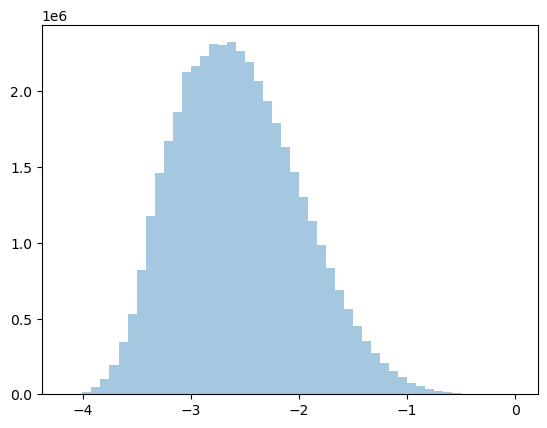

In [5]:
Uflat = U.ravel()
Uflat = Uflat[Uflat != 0]
print(Uflat.shape)
sns.distplot(np.log10(Uflat / Uflat.max()), kde=False)

(1323581,)


/tmp/ipykernel_1560/1289523016.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(Sflat / Sflat_max), kde=False)


<Axes: >

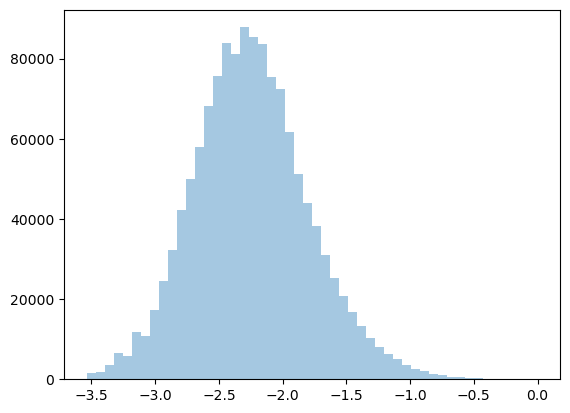

In [6]:
Sflat = S.ravel()
Sflat = Sflat[Sflat != 0]
Sflat_max = Sflat.max()
print(Sflat.shape)
sns.distplot(np.log10(Sflat / Sflat_max), kde=False)

S was bugged, i guess it wasn't super important lmao

(109962599,)


/tmp/ipykernel_1560/2378610652.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(Gflat / Gflat_max), kde=False)


<Axes: >

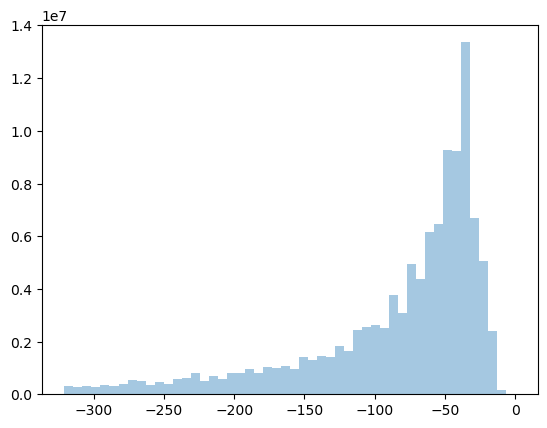

In [7]:
Gflat = G.ravel()
Gflat = Gflat[Gflat != 0]
Gflat_max = Gflat.max()
print(Gflat.shape)
sns.distplot(np.log10(Gflat / Gflat_max), kde=False)

Notes

* They seem mostly log-normal
* A weighted sum might be weird
* If we add in a secondary context, what form would it take?

## Creating an item exposure fusion module

In [4]:
from Data.loadDatasetFiles import loadDatasetFiles
from Data.readDataSizes import readDataSizes
from Models.utils import readTrainingData

datasetFiles = loadDatasetFiles('Yelp')
dataDictionary = readDataSizes('Yelp', datasetFiles)
users, pois = dataDictionary['users'], dataDictionary['pois']
trainingMatrix, userCheckinCounts, poiCheckinCounts = readTrainingData(datasetFiles['train'], users['count'], pois['count'], False)

Loading Yelp dataset files ...
Yelp dataset files have been loaded for processing!
Reading the 'dataSize' file to prepare further processing...
Yelp dataset contains 7135 users, 16621 locations, and 595 categories!
Reading training data...
Setting threshold to median repeating POI ratio of 0.7
Setting threshold to 80th prc. of POI visits of 66.0


In [5]:
poiCheckinCounts.head()

,checkins,short_head
poi_id,,
196,1596,True
3170,1297,True
1515,1277,True
1092,1085,True
1582,1085,True


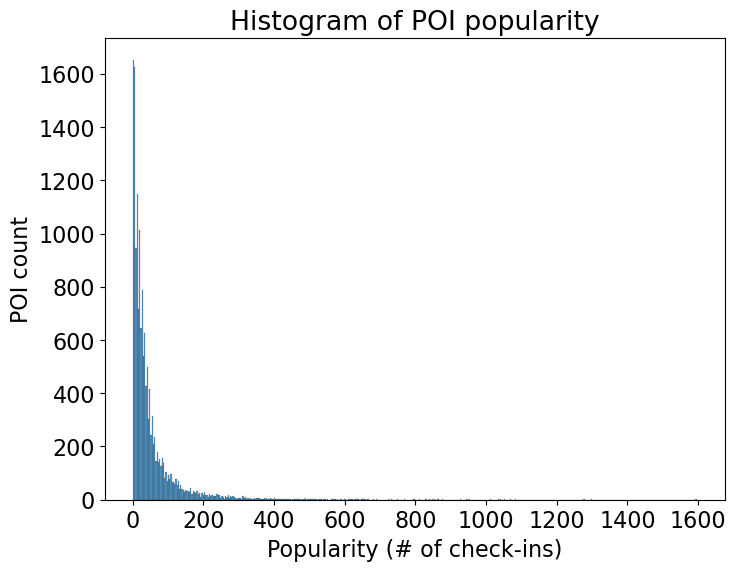

In [7]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(poiCheckinCounts.checkins, ax=ax)
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count')
ax.set_title('Histogram of POI popularity')
fig.savefig('images/yelp-popularity-histogram.png')

In [8]:
# binning
poiHist = poiCheckinCounts.groupby('checkins')[['short_head']].count().rename(columns={'short_head': 'frequency'}).sort_values(by='frequency', ascending=False)
poiHist = poiHist.reset_index()
poiHist.head()


,checkins,frequency
0,4,868
1,5,669
2,3,488
3,8,390
4,9,373


In [9]:
xs = np.arange(0, 1600, 10)

freqs, bins = np.histogram(poiCheckinCounts['checkins'], bins=xs)
bins = bins[1:]
nonzero = (freqs != 0)

### Exponential

In [10]:
x = np.log10(bins[nonzero])
t = np.log10(freqs[nonzero])

In [11]:
from sklearn.linear_model import LinearRegression, Ridge

powerlaw1 = LinearRegression().fit(x[:, np.newaxis], t)
powerlaw2 = Ridge().fit(x[:, np.newaxis], t)
powerlaw3 = Ridge(alpha=10.0).fit(x[:, np.newaxis], t)

coef_a1, coef_b1 = 10**powerlaw1.intercept_, powerlaw1.coef_[0]
print(f"Linear Reg: y = {coef_a1:.2f} * x^{coef_b1:.2f}")
coef_a2, coef_b2 = 10**powerlaw2.intercept_, powerlaw2.coef_[0]
print(f"Ridge: y = {coef_a2:.2f} * x^{coef_b2:.2f}")
coef_a3, coef_b3 = 10**powerlaw3.intercept_, powerlaw3.coef_[0]
print(f"Ridge, alpha=10: y = {coef_a3:.2f} * x^{coef_b3:.2f}")

Linear Reg: y = 6931237.61 * x^-2.28
Ridge: y = 3109447.63 * x^-2.14
Ridge, alpha=10: y = 37625.05 * x^-1.40


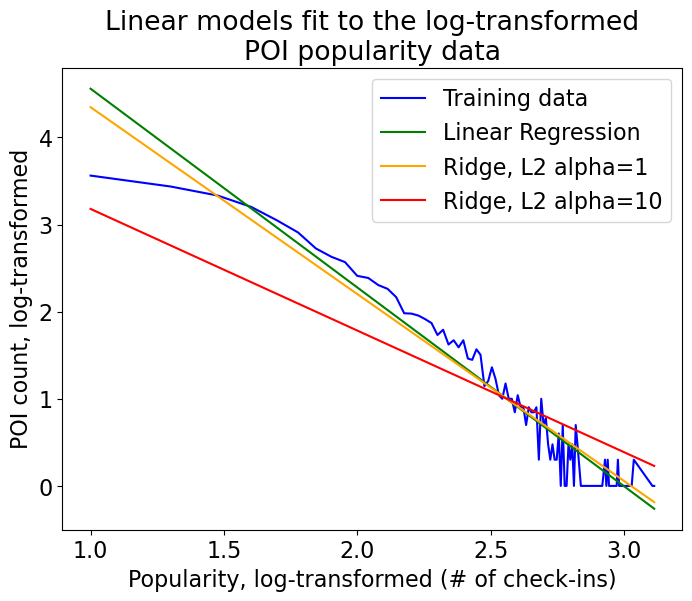

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=x, y=t, ax=ax, color='blue', label='Training data')
sns.lineplot(x=x, y=powerlaw1.predict(x[:, np.newaxis]), ax=ax, color='green', label='Linear Regression')
sns.lineplot(x=x, y=powerlaw2.predict(x[:, np.newaxis]), ax=ax, color='orange', label='Ridge, L2 alpha=1')
sns.lineplot(x=x, y=powerlaw3.predict(x[:, np.newaxis]), ax=ax, color='red', label='Ridge, L2 alpha=10')
ax.legend()
ax.set_xlabel('Popularity, log-transformed (# of check-ins)')
ax.set_ylabel('POI count, log-transformed')
ax.set_title('Linear models fit to the log-transformed\nPOI popularity data')

fig.savefig('images/yelp-linear-models.png')

### Linear

In [18]:
x = bins[nonzero]
t = freqs[nonzero]

linear1 = LinearRegression().fit(x[:, np.newaxis], t)
linear2 = Ridge().fit(x[:, np.newaxis], t)
linear3 = Ridge(alpha=100.0).fit(x[:, np.newaxis], t)

coef_a1, coef_b1 = linear1.intercept_, linear1.coef_[0]
print(f"Linear Reg: y = {coef_a1:.2f} + {coef_b1:.2f}*x")
coef_a2, coef_b2 = linear2.intercept_, linear2.coef_[0]
print(f"Ridge: y = {coef_a2:.2f} + {coef_b2:.2f}*x")
coef_a3, coef_b3 = linear3.intercept_, linear3.coef_[0]
print(f"Ridge, alpha=10: y = {coef_a3:.2f} + {coef_b3:.2f}*x")

Linear Reg: y = 540.35 + -0.75*x
Ridge: y = 540.35 + -0.75*x
Ridge, alpha=10: y = 540.34 + -0.75*x


Text(0.5, 1.0, 'Linear models fit to the POI popularity data')

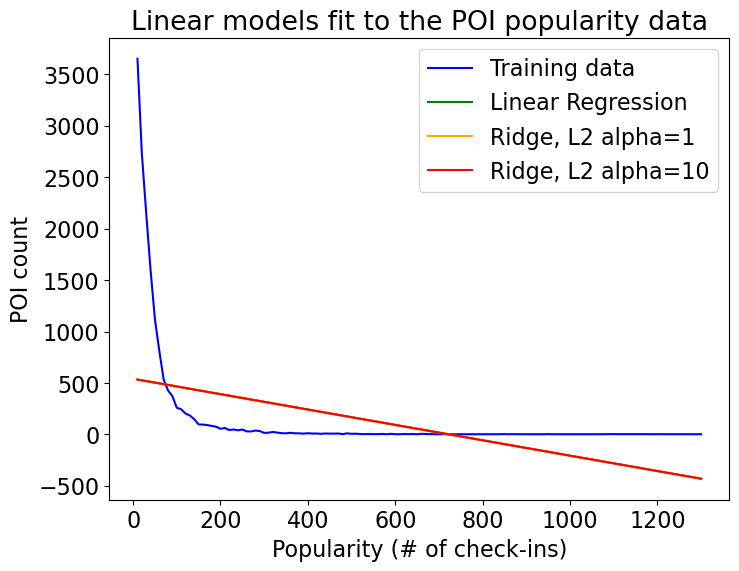

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=x, y=t, ax=ax, color='blue', label='Training data')
sns.lineplot(x=x, y=linear1.predict(x[:, np.newaxis]), ax=ax, color='green', label='Linear Regression')
sns.lineplot(x=x, y=linear2.predict(x[:, np.newaxis]), ax=ax, color='orange', label='Ridge, L2 alpha=1')
sns.lineplot(x=x, y=linear3.predict(x[:, np.newaxis]), ax=ax, color='red', label='Ridge, L2 alpha=10')
ax.legend()
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count')
ax.set_title('Linear models fit to the POI popularity data')

# fig.savefig('images/yelp-linear-models.png')

### Sigmoidal

In [20]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def logit(x):
  return np.log(x) - np.log(1 - x)

In [21]:
x = bins[nonzero]
t = freqs[nonzero]

In [ ]:
from sklearn.linear_model import LogisticRegression

logit1 = LogisticRegression().fit(x[:, np.newaxis], t)
logit2 = LogisticRegression(C=0.1).fit(x[:, np.newaxis], t)
logit3 = LogisticRegression(penalty=None).fit(x[:, np.newaxis], t)

Text(0.5, 1.0, 'Logistic models fit to the POI popularity data')

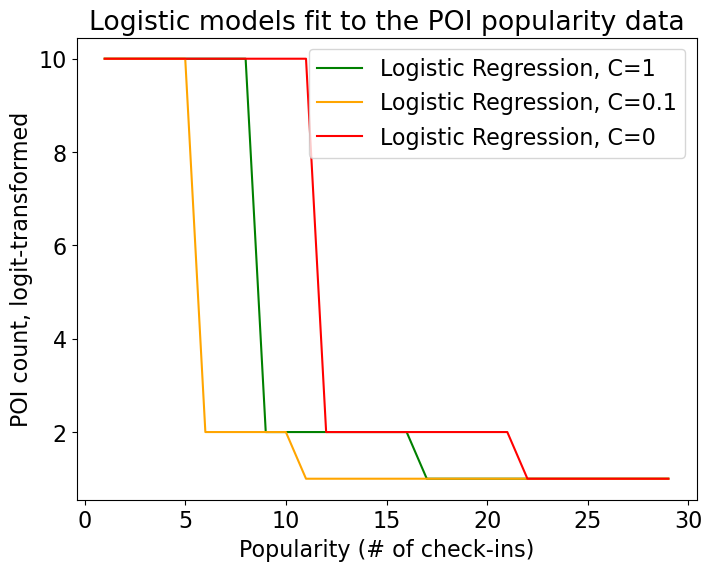

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

xsub = np.arange(1,30)

# sns.lineplot(x=x, y=t, ax=ax, color='blue', label='Training data')
sns.lineplot(x=xsub, y=logit1.predict(xsub[:, np.newaxis]), ax=ax, color='green', label='Logistic Regression, C=1')
sns.lineplot(x=xsub, y=logit2.predict(xsub[:, np.newaxis]), ax=ax, color='orange', label='Logistic Regression, C=0.1')
sns.lineplot(x=xsub, y=logit3.predict(xsub[:, np.newaxis]), ax=ax, color='red', label='Logistic Regression, C=0')
ax.legend()
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count, logit-transformed')
ax.set_title('Logistic models fit to the POI popularity data')

# fig.savefig('images/yelp-logistic-models.png')

In [24]:
# plotting all of them
from sklearn.preprocessing import MinMaxScaler

coef_a, coef_b = 10**powerlaw3.intercept_, powerlaw3.coef_[0]

xsub = np.arange(1,1000)
ysub_powerlaw = MinMaxScaler().fit_transform(np.log(coef_a * (xsub ** coef_b))[:, np.newaxis])
ysub_linear = MinMaxScaler().fit_transform(linear3.predict(xsub[:, np.newaxis])[:, np.newaxis])
ysub_logistic = MinMaxScaler().fit_transform(logit3.predict(xsub[:, np.newaxis])[:, np.newaxis])

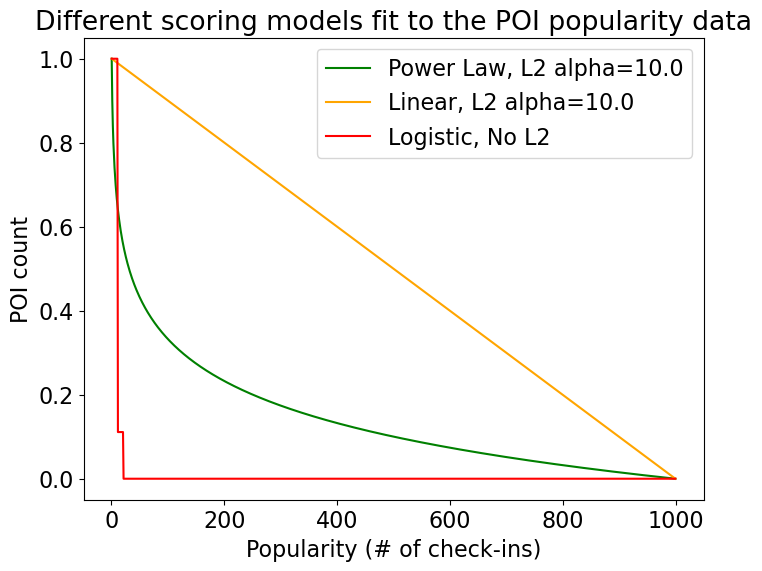

In [25]:
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=xsub, y=ysub_powerlaw[:, 0], ax=ax, color='green', label='Power Law, L2 alpha=10.0')
sns.lineplot(x=xsub, y=ysub_linear[:, 0], ax=ax, color='orange', label='Linear, L2 alpha=10.0')
sns.lineplot(x=xsub, y=ysub_logistic[:, 0], ax=ax, color='red', label='Logistic, No L2')
ax.legend()
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count')
ax.set_title('Different scoring models fit to the POI popularity data')

fig.savefig('images/different_models_provider_fairness.png')

In [26]:
coef_a, coef_b = 10**powerlaw3.intercept_, powerlaw3.coef_[0]
ts = coef_a * (xs ** coef_b)

/tmp/ipykernel_13436/3414088482.py:2: RuntimeWarning: divide by zero encountered in power
  ts = coef_a * (xs ** coef_b)


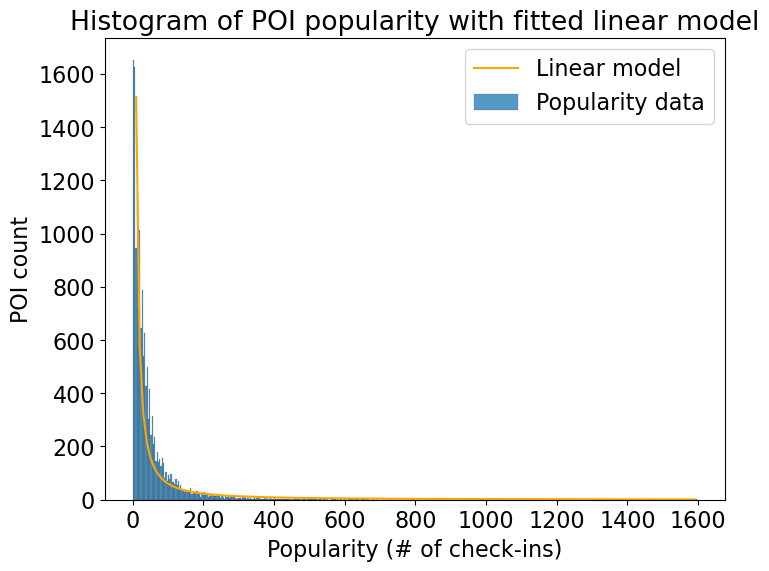

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(poiCheckinCounts.checkins, ax=ax, label='Popularity data')
sns.lineplot(x=xs, y=ts, ax=ax, color='orange', label='Linear model')
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('POI count')
ax.set_title('Histogram of POI popularity with fitted linear model')

fig.savefig('images/yelp-histogram-with-model.png')

Text(0.5, 1.0, 'Unnormalized provider fairness score')

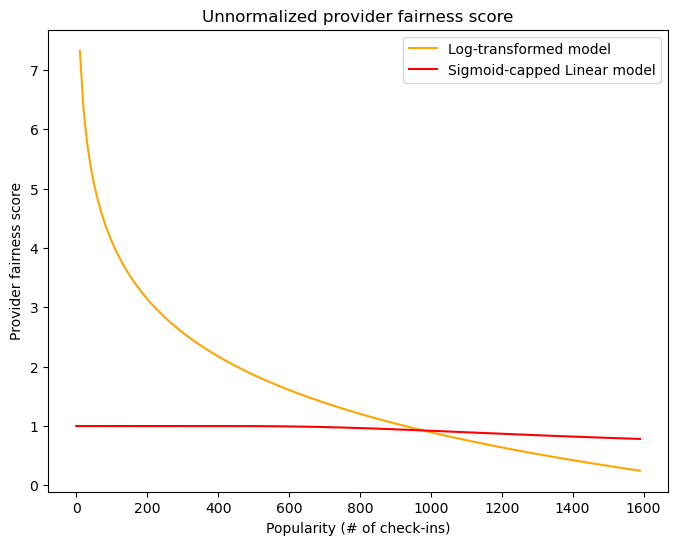

In [23]:

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=xs, y=np.log(ts), ax=ax, color='orange', label='Log-transformed model')
sns.lineplot(x=xs, y=sigmoid(ts), ax=ax, color='red', label='Sigmoid-capped Linear model')
ax.set_xlabel('Popularity (# of check-ins)')
ax.set_ylabel('Provider fairness score')
ax.set_title('Unnormalized provider fairness score')

# fig.savefig('images/yelp-logmodel.png')